# Projeto de Predição de Arrecadação para SESI/SENAI

Este notebook demonstra uma abordagem completa para o desafio de predição da variável `arrecadação_setor_x` utilizando dados de arrecadação com base em RAIS-CAGED. As etapas abordadas são:
- Importação e configuração das bibliotecas
- Leitura e exploração dos dados (EDA)
- Pré-processamento e engenharia de features
- Divisão dos dados em treino e teste
- Modelagem com Regressão Linear, Random Forest, Gradient Boosting e XGBoost
- Otimização com GridSearchCV para Random Forest
- Avaliação, visualização dos resíduos e interpretação dos resultados

Ambiente: **Windows**, **VSCode** com extensão **Jupyter** e **Python 3.12.8**.

In [16]:
# Importação das bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para modelagem e avaliação
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos de regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configurações de visualização
sns.set(style="whitegrid")
%matplotlib inline


## Leitura dos Dados e Extração de Features Temporais

Nesta seção, carregamos o arquivo `dados_finais.xlsx`, convertemos a coluna `Data` para o tipo datetime, extraímos `Ano` e `Mes` (no formato numérico) e removemos a coluna original `Data`.

In [17]:
# Leitura do arquivo Excel
df_original = pd.read_excel('dados_finais.xlsx')

# Converter 'Data' para datetime e extrair 'Ano' e 'Mes'
df_original['Ano'] = pd.to_datetime(df_original['Data'], format='%Y-%m-%d').dt.year
df_original['Mes'] = pd.to_datetime(df_original['Data'], format='%Y-%m-%d').dt.month

# Remover a coluna 'Data'
df_original = df_original.drop('Data', axis=1)

# Exibir as primeiras linhas
df_original.head()

,arrecadação_setor_x,emprego_setor_x,producao_industrial_setor_y,taxa_cambio,emprego_industria_transformacao,emprego_industria_extracao,emprego_construcao,emprego,producao_aco,producao_industria_transformacao,utilizacao_capacidade_instalada_industria,venda_veiculos,Ano,Mes
0,33000.000000,12000.000000,9374.863229,1.660535,7228679,191528,1790665,31638855,149.57,118.6,84.6,274542,2008,5
1,33000.000000,12000.000000,9915.599759,1.618857,7279456,193614,1835755,31983823,147.76,119.7,84.7,292422,2008,6
2,23820.333318,32061.314214,6795.705856,1.591413,7315398,195298,1879080,32216220,162.45,120.2,85.2,305384,2008,7
3,26640.846801,38524.893276,12460.406213,1.612314,7364355,197176,1922367,32485038,158.12,118.4,85.0,299556,2008,8
4,31970.953526,41516.585747,7309.846622,1.799568,7479455,198864,1961567,32796043,151.68,120.9,84.4,286610,2008,9


## Análise Exploratória dos Dados (EDA)

Nesta etapa, verificamos informações gerais, a existência de valores nulos e visualizamos a distribuição da variável alvo e a matriz de correlação.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   arrecadação_setor_x                        200 non-null    float64
 1   emprego_setor_x                            200 non-null    float64
 2   producao_industrial_setor_y                200 non-null    float64
 3   taxa_cambio                                200 non-null    float64
 4   emprego_industria_transformacao            200 non-null    int64  
 5   emprego_industria_extracao                 200 non-null    int64  
 6   emprego_construcao                         200 non-null    int64  
 7   emprego                                    200 non-null    int64  
 8   producao_aco                               200 non-null    float64
 9   producao_industria_transformacao           200 non-null    float64
 10  utilizacao_capacidade_inst

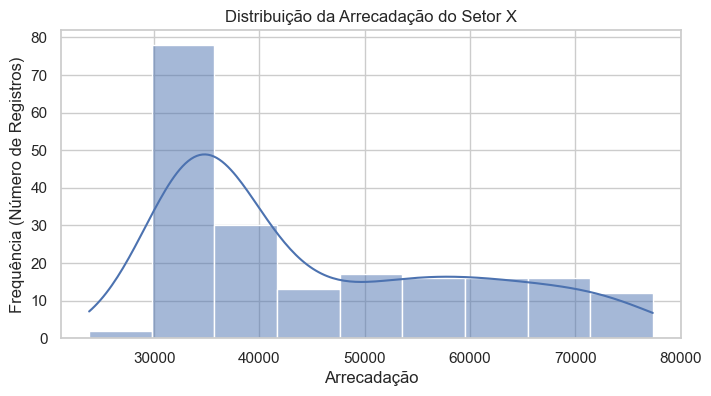

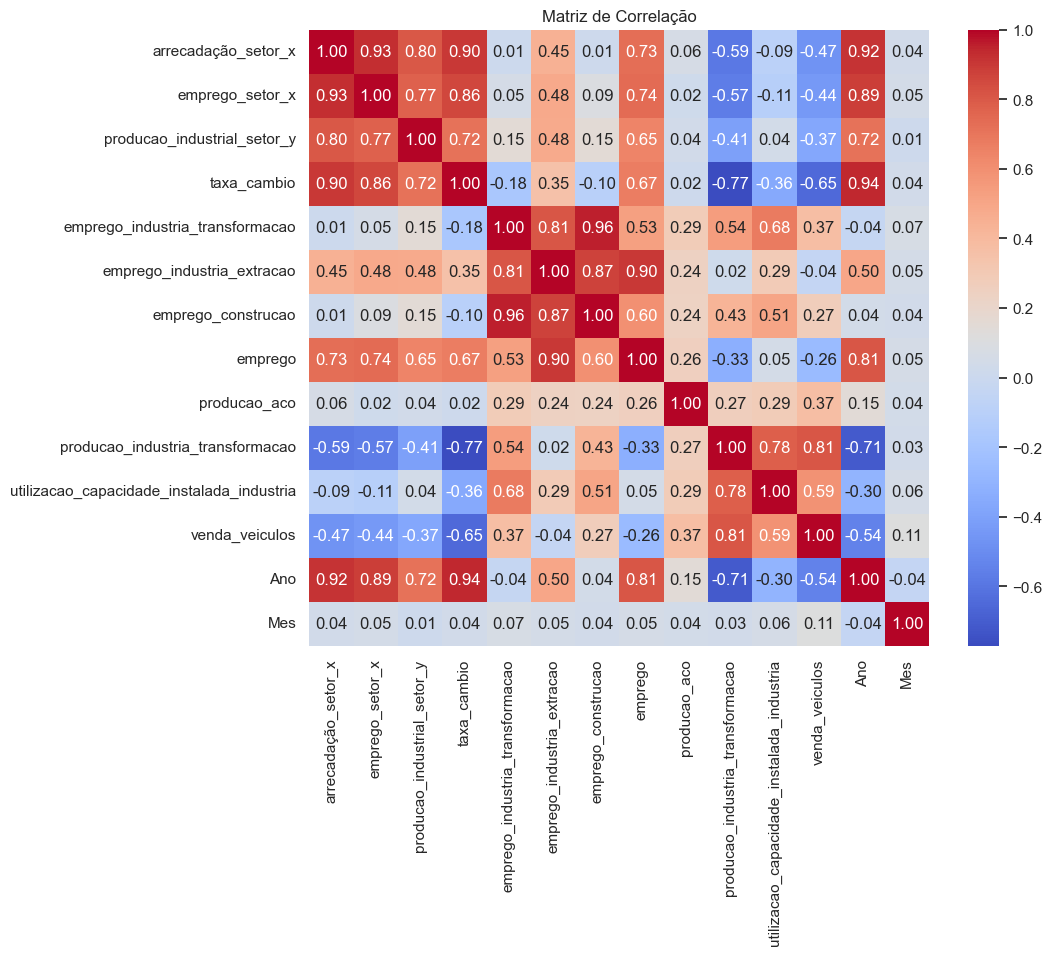

In [18]:
# Informações gerais do dataset
print(df_original.info())
print(df_original.describe())

# Valores nulos por coluna
print('Valores nulos por coluna:')
print(df_original.isnull().sum())

# Distribuição da variável alvo
plt.figure(figsize=(8, 4))
sns.histplot(df_original['arrecadação_setor_x'], kde=True)
plt.title('Distribuição da Arrecadação do Setor X')
plt.xlabel('Arrecadação')
plt.ylabel('Frequência (Número de Registros)')
plt.show()

# Matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_original.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

## Pré-processamento e Engenharia de Features

Nesta etapa, removemos as colunas que apresentam correlação menor ou igual a zero com a variável alvo, a fim de reduzir ruído. Em seguida, configuramos o pipeline para o pré-processamento numérico (imputação e escalonamento).

In [19]:
# Calcular a correlação com a variável alvo
correlacao_com_alvo = df_original.corr()['arrecadação_setor_x']
colunas_negativas = correlacao_com_alvo[correlacao_com_alvo <= 0].index.tolist()
print('Colunas removidas (correlação <= 0):', colunas_negativas)

# Criar o DataFrame filtrado para modelagem
df = df_original.drop(columns=colunas_negativas)

# Identificar colunas numéricas
numero_colunas = df.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
numero_colunas.remove('arrecadação_setor_x')  # removendo a variável alvo

# Criar o pipeline para colunas numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Configurar o pré-processador
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numero_colunas)
])

print('Pré-processamento configurado com sucesso!')

Colunas removidas (correlação <= 0): ['producao_industria_transformacao', 'utilizacao_capacidade_instalada_industria', 'venda_veiculos']
Pré-processamento configurado com sucesso!


## Divisão dos Dados

Separamos as variáveis independentes (`X`) da variável alvo (`y`) e dividimos os dados em conjuntos de treino e teste.

In [20]:
# Separar as variáveis
X = df.drop('arrecadação_setor_x', axis=1)
y = df['arrecadação_setor_x']

# Dividir os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

print('Divisão realizada:')
print('Treino:', X_treino.shape, '| Teste:', X_teste.shape)

Divisão realizada:
Treino: (160, 10) | Teste: (40, 10)


## Função Auxiliar: Treinamento, Predição e Avaliação

Esta função auxilia no treinamento de um modelo, realização da predição, cálculo das métricas (MSE e R²) e plotagem dos resíduos.

In [21]:
def treino_avaliacao(model, X_treino, y_treino, X_teste, y_teste, model_name):
    """
    Treina o modelo, faz predições e exibe MSE, R² e o histograma dos resíduos.
    """
    # Treinamento
    model.fit(X_treino, y_treino)
    
    # Predição
    y_predicao = model.predict(X_teste)
    
    # Cálculo das métricas
    mse = mean_squared_error(y_teste, y_predicao)
    r2 = r2_score(y_teste, y_predicao)
    
    print(f'{model_name} - MSE: {mse:.2f}, R²: {r2:.2f}')
    
    # Visualização dos resíduos
    plt.figure(figsize=(8,4))
    sns.histplot(y_teste - y_predicao, kde=True)
    plt.title(f'Distribuição dos Resíduos - {model_name}')
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.show()
    
    return mse, r2


## Modelagem: Regressão Linear

Aplicamos a Regressão Linear utilizando o pipeline configurado com o pré-processador definido anteriormente.

Regressão Linear - MSE: 11186196.99, R²: 0.93


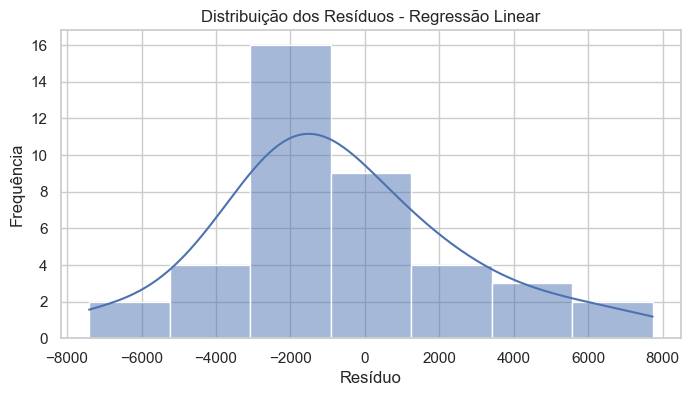

In [22]:
# Criar pipeline para Regressão Linear
pipeline_rl = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Treinar e avaliar a Regressão Linear
mse_rl, r2_rl = treino_avaliacao(pipeline_rl, X_treino, y_treino, X_teste, y_teste, 'Regressão Linear')

## Modelagem: Regressão Linear Ajustada

Nesta abordagem, removemos manualmente colunas que visualmente não estão diretamente relacionadas ao FPAS 507 ("taxa_cambio", "emprego", "venda_veiculos", "Ano" e "Mes").

Regressão Linear Ajustada - MSE: 8468105.53, R²: 0.95


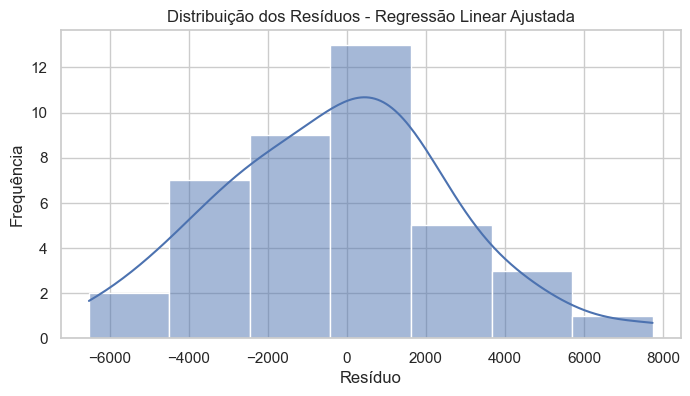

In [23]:
# Remover as colunas especificadas
df_ajustado = df_original.drop(['taxa_cambio', 'emprego', 'venda_veiculos', 'Ano', 'Mes'], axis=1)

# Separar variáveis
X_ajustado = df_ajustado.drop('arrecadação_setor_x', axis=1)
y_ajustado = df_ajustado['arrecadação_setor_x']

# Dividir em treino e teste
X_treino_ajustado, X_teste_ajustado, y_treino_ajustado, y_teste_ajustado = train_test_split(X_ajustado, y_ajustado, test_size=0.2, random_state=42)

# Identificar colunas numéricas para o DataFrame ajustado
numero_colunas_ajustado = X_treino_ajustado.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

# Pipeline para o pré-processamento dos dados ajustados
num_pipeline_ajustado = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_ajustado = ColumnTransformer(transformers=[
    ('num', num_pipeline_ajustado, numero_colunas_ajustado)
])

# Pipeline para Regressão Linear Ajustada
pipeline_rl_ajustado = Pipeline(steps=[
    ('preprocessor', preprocessor_ajustado),
    ('regressor', LinearRegression())
])

# Treinar e avaliar a Regressão Linear Ajustada
mse_rl_ajustado, r2_rl_ajustado = treino_avaliacao(pipeline_rl_ajustado, X_treino_ajustado, y_treino_ajustado, X_teste_ajustado, y_teste_ajustado, 'Regressão Linear Ajustada')

## Modelagem: Random Forest

Utilizamos o modelo Random Forest com o pipeline configurado e avaliamos sua performance.

Random Forest - MSE: 2388683.88, R²: 0.99


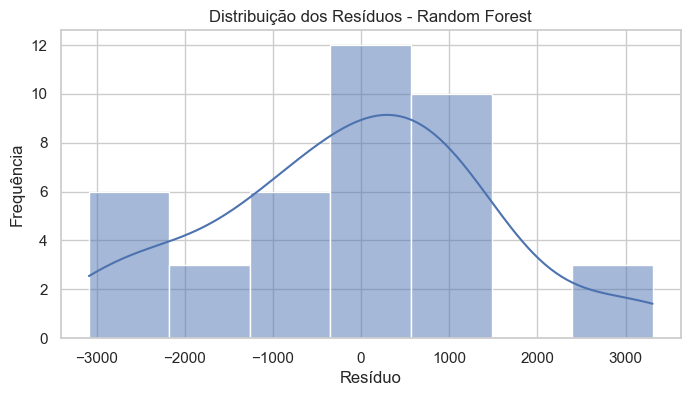

In [24]:
# Pipeline com Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Treinar e avaliar Random Forest
mse_rf, r2_rf = treino_avaliacao(pipeline_rf, X_treino, y_treino, X_teste, y_teste, 'Random Forest')

## Modelagem: Gradient Boosting

Utilizamos o modelo GradientBoostingRegressor em um pipeline similar.

Gradient Boosting - MSE: 2639490.04, R²: 0.98


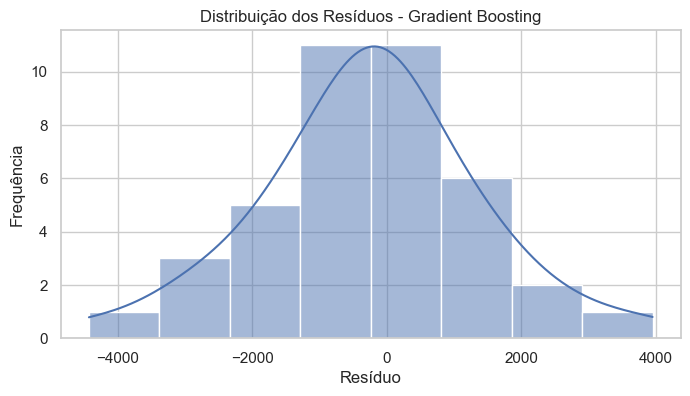

In [25]:
# Pipeline com Gradient Boosting
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Treinar e avaliar Gradient Boosting
mse_gb, r2_gb = treino_avaliacao(pipeline_gb, X_treino, y_treino, X_teste, y_teste, 'Gradient Boosting')

## Modelagem: XGBoost

Utilizamos o modelo XGBRegressor em um pipeline, definindo o parâmetro `objective='reg:squarederror'` para regressão.

XGBoost - MSE: 2333951.96, R²: 0.99


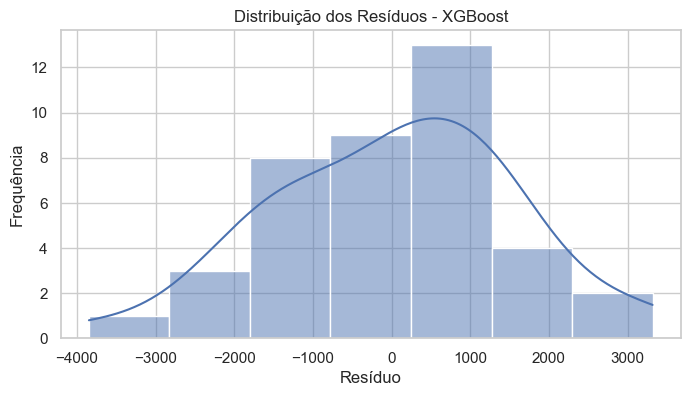

In [26]:
# Pipeline com XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Treinar e avaliar XGBoost
mse_xgb, r2_xgb = treino_avaliacao(pipeline_xgb, X_treino, y_treino, X_teste, y_teste, 'XGBoost')

## Otimização do Modelo Random Forest com GridSearchCV

Utilizamos o GridSearchCV para encontrar a melhor combinação de hiperparâmetros para o Random Forest.

Melhores parâmetros encontrados: {'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Random Forest (Com Tuning) - MSE: 2300187.61, R²: 0.99


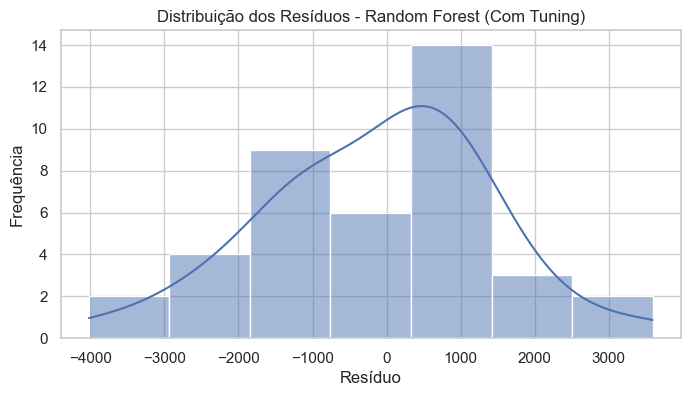

In [27]:
# Definindo os parâmetros para o GridSearchCV
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__max_features': ['sqrt', 'log2']
}

# GridSearch para o modelo Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_treino, y_treino)

print('Melhores parâmetros encontrados:', grid_search_rf.best_params_)

# Utilizar o melhor modelo
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_teste)

mse_rf_tunado = mean_squared_error(y_teste, y_pred_best_rf)
r2_rf_tunado = r2_score(y_teste, y_pred_best_rf)
print(f'Random Forest (Com Tuning) - MSE: {mse_rf_tunado:.2f}, R²: {r2_rf_tunado:.2f}')

# Visualizar resíduos do modelo Random Forest
plt.figure(figsize=(8,4))
sns.histplot(y_teste - y_pred_best_rf, kde=True)
plt.title('Distribuição dos Resíduos - Random Forest (Com Tuning)')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

## Importância das Features (Random Forest - Com Tuning)

Plotamos a importância das features usando o melhor modelo Random Forest obtido via GridSearchCV.

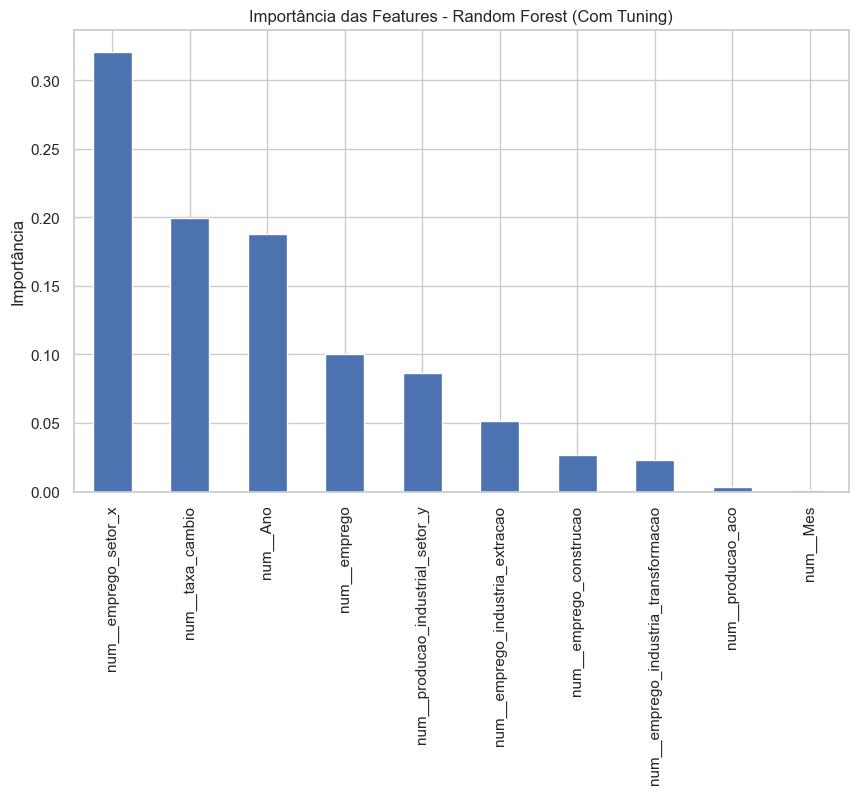

In [28]:
# Extraindo a importância das features do modelo Random Forest
importances = best_rf.named_steps['regressor'].feature_importances_

# Obter os nomes das features após o pré-processamento
feature_names = preprocessor.get_feature_names_out()
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plotando a importância das features
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importância das Features - Random Forest (Com Tuning)')
plt.ylabel('Importância')
plt.show()

## Considerações Finais

Foram exploradas diversas abordagens para a predição de `arrecadação_setor_x`, incluindo Regressão Linear (com e sem ajuste) e modelos baseados em árvore (Random Forest, Gradient Boosting e XGBoost). A otimização via GridSearchCV para o Random Forest demonstrou ser adequado para esse conjunto de dados. 

A comparação entre os modelos permite fundamentar a escolha do modelo final.

In [29]:
# Resumo Final da Predição
print("================================================")
print("RESUMO DA PREDIÇÃO")
print("================================================")
print(f"Regressão Linear: MSE = {mse_rl:.2f}, R² = {r2_rl:.2f}")
print(f"Regressão Linear Ajustado: MSE = {mse_rl_ajustado:.2f}, R² = {r2_rl_ajustado:.2f}")
print(f"Random Forest (Sem Tuning): MSE = {mse_rf:.2f}, R² = {r2_rf:.2f}")
print(f"Random Forest (Com Tuning): MSE = {mse_rf_tunado:.2f}, R² = {r2_rf_tunado:.2f}")
print(f"Gradient Boosting: MSE = {mse_gb:.2f}, R² = {r2_gb:.2f}")
print(f"XGBoost: MSE = {mse_xgb:.2f}, R² = {r2_xgb:.2f}")
print("------------------------------------------------")
print("Melhores parâmetros encontrados para o Random Forest (Com Tuning):")
print(grid_search_rf.best_params_)
print("================================================")

# Determinar o melhor modelo com base no menor MSE
mse_dict = {
    "Regressão Linear": mse_rl,
    "Regressão Linear Ajustado": mse_rl_ajustado,
    "Random Forest (Sem Tuning)": mse_rf,
    "Random Forest (Com Tuning)": mse_rf_tunado,
    "Gradient Boosting": mse_gb,
    "XGBoost": mse_xgb
}
best_model = min(mse_dict, key=mse_dict.get)
print(f"\nO modelo com melhor desempenho (menor MSE) foi: {best_model}")


RESUMO DA PREDIÇÃO
Regressão Linear: MSE = 11186196.99, R² = 0.93
Regressão Linear Ajustado: MSE = 8468105.53, R² = 0.95
Random Forest (Sem Tuning): MSE = 2388683.88, R² = 0.99
Random Forest (Com Tuning): MSE = 2300187.61, R² = 0.99
Gradient Boosting: MSE = 2639490.04, R² = 0.98
XGBoost: MSE = 2333951.96, R² = 0.99
------------------------------------------------
Melhores parâmetros encontrados para o Random Forest (Com Tuning):
{'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}

O modelo com melhor desempenho (menor MSE) foi: Random Forest (Com Tuning)
